In [22]:
import math, collections, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats

# Global utilities
ureg    = pint_pandas.PintType.ureg
dtime_t = pd.to_timedelta(1, unit='s')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_csv_mec(path, pint=True):
    '''Import Mecmesin data'''
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

def pint2dtime(times):
    '''Converts Pint time values to Pandas deltatime.'''
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        # Strip "pint[...]" text wrapping the unit string.
        unit = str(times.dtype)[5:-1]
    )

def event_times(event_coding):
    '''Extracts event start times from Mecmesin event coding.'''
    return event_coding[event_coding.diff() == -1].index

def time2state(times, events):
    '''
    Labels each time with an associated state based on Mecmesin event start times.
    I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
    '''
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

# User inputs
data = [
    dotdict(
        data      = '00 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = '01 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = '02 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = '03 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = '04 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = '05 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
]

for dat in data:
    # Preprocess
    dat.df       = read_csv_mec(dat.data)
    dat.df.index = pint2dtime(dat.df.Time)
    dat.events   = event_times(dat.df.Event)
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)
    dat.df.dropna(inplace=True)
    
    # Append flexural modulus estimate
    # dat.df['FlexMod'] = ((1/16) * (dat.df.Force / dat.df.Distance) * (dat.length**3 / dat.width / dat.thickness**3)).pint.to(ureg.GPa)

    # Create Pint-unitless data copy to suppress errors when plotting.
    # Remove unit headers from dequantify(). These cause errors with column access.
    dat.dfdq = dat.df.pint.dequantify()
    dat.dfdq.columns = dat.dfdq.columns.droplevel(-1)

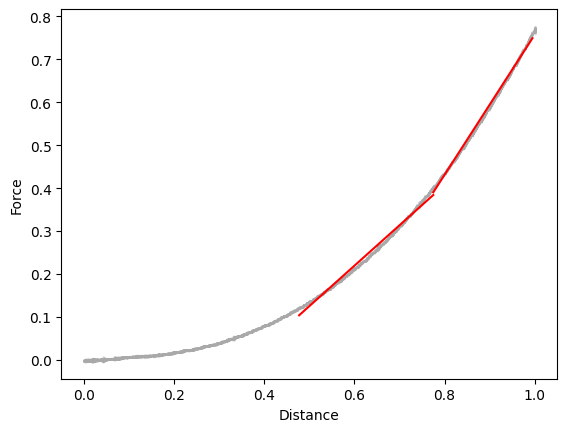

In [33]:
# Returns Standard Error of the Mean (SEM): std / sqrt(n)
def sem(n, sum1, sum2):
    return np.sqrt((sum2 - sum1*sum1/n) / (n-1)) / np.sqrt(n)

# Checks if all elements in series are equivalent
def varies(s):
    return not (s == s.iloc[0]).all()

# Returns plottable line segment
def region_line(x0, x1, slope, intercept):
    f = lambda x: x * slope + intercept
    return [x0, x1], [f(x0), f(x1)]

# Converges on the largest linear span in a curve with least-squares regression and quasi-Monte Carlo sampling.
# Statistical modification of https://doi.org/10.1063/1.4969058
# Standard Error of the Mean (SEM) stopping rule: https://www.maxvalue.com/tip025.htm
def large_linear_region(df, r2_limit, sem_goal, qmc_kernel=stats.qmc.LatinHypercube(1)):
    assert len(df.columns) == 2
    x_unique = np.unique(df[df.columns[0]])
    n_unique = len(x_unique)
    Region   = collections.namedtuple('Region', 'i x0 x1 dx soln')
    best_fit = None
    r_sum1, r_sum2 = 0, 0
    for i in itertools.takewhile(lambda i: i < 2 or sem(i, r_sum1, r_sum2) > sem_goal, itertools.count()):
        x0, x1 = sorted(x_unique[[np.int_(qmc_kernel.random(n=2) * n_unique)]][0].squeeze())
        dx = x1 - x0
        soln = stats.linregress(*[v.squeeze() for v in np.hsplit(df[(df[df.columns[0]] >= x0) & (df[df.columns[0]] <= x1)].values, 2)])
        r_sum1 += soln.rvalue
        r_sum2 += (r2 := soln.rvalue*soln.rvalue)
        if r2 >= r2_limit and (not best_fit or dx > best_fit.dx):
            best_fit = Region(i, x0, x1, dx, soln)
    return best_fit

def find_linear_regions(df, max_depth, **kwargs):
    if max_depth == 0 or len(df) <= 2 or not varies(df[df.columns[0]]):
        return []
    for _ in range(max_depth):
        if lin := large_linear_region(df, **kwargs):
            break
    if lin:
        return find_linear_regions(df[df[df.columns[0]] <= lin.x0], max_depth-1, **kwargs) + [lin] + find_linear_regions(df[df[df.columns[0]] >= lin.x1], max_depth-1, **kwargs)
    return []

# Find linear regions
df = dat.dfdq[(dat.df.Cycle==0) & (dat.df.Loading==0)][['Distance', 'Force']]
lines = find_linear_regions(df, max_depth=2, r2_limit=0.99, sem_goal=0.001)

# Plot data
fig, ax = plt.subplots()
df.plot.scatter('Distance', 'Force', s=0.001, c='darkgrey', ax=ax)
for lin in lines:
    ax.plot(*region_line(lin.x0, lin.x1, lin.soln.slope, lin.soln.intercept), c='red')

In [92]:
a = itertools.combinations([1, 2, 3, 1], 2)
list(a)

[(1, 2), (1, 3), (1, 1), (2, 3), (2, 1), (3, 1)]

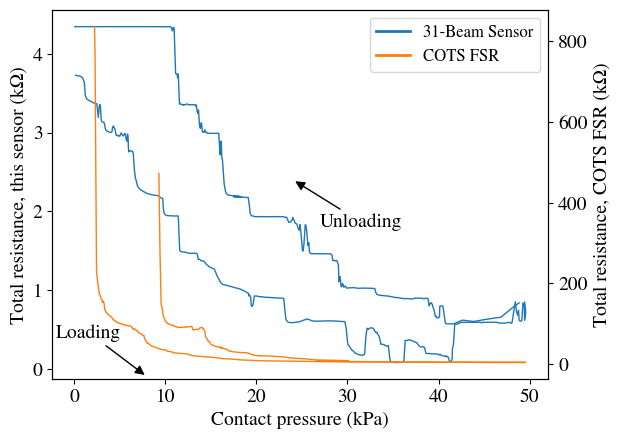

In [2]:
mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'

fig, ax = plt.subplots()
axes    = [ax, ax.twinx()]
# bx      = inset_axes(ax, width='40%', height='40%', bbox_to_anchor=(0.06, 0, 1, 1), bbox_transform=ax.transAxes)
lines   = []

# Draw experiment image
# bx.imshow(plt.imread('inset (unsure if same sensor!).png'))
# bx.set_xticks([])
# bx.set_yticks([])

# Plot R/P
for (cycle, loading), gf in data[0].dfdq.dropna().groupby(['Cycle', 'Loading']):
    if cycle == 2:
        plot = axes[0].plot(gf.Pressure, gf.Resistance, lw=1, color=palette[0], label='31-Beam Sensor')
        if loading:
            lines += plot

# Plot COTS FSR R/P
for (cycle, loading), gf in data[1].dfdq.dropna().groupby(['Cycle', 'Loading']):
    if cycle == 2:
        plot = axes[1].plot(gf.Pressure, gf.Resistance, lw=1, color=palette[1], label='COTS FSR')
        if loading:
            lines += plot

# Draw loading/unloading arrows
axes[0].annotate('Loading', xytext=(-2, 0.4), xy=(8, -0.1), arrowprops=dict(arrowstyle='-|>', color='black'))
axes[0].annotate('Unloading', xytext=(27, 1.8), xy=(24, 2.4), arrowprops=dict(arrowstyle='-|>', color='black'))

# Style axes
axes[0].set_xlabel('Contact pressure (kPa)')
axes[0].set_ylabel('Total resistance, this sensor (kΩ)')
axes[1].set_ylabel('Total resistance, COTS FSR (kΩ)')

# Style legend
leg = ax.legend(
    lines,
    [l.get_label() for l in lines],
    loc='upper right',
    fontsize=12,
)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()